# Building a Recommender System with Amazon SageMaker Factorization Machines and BlazingText

---

---

## Background

- Recommender systems were a catalyst for ML's popularity (Amazon, Netflix Prize)
- User item matrix factorization is a core methodology
- Factorization machines combine linear prediction with a factorized representation of pairwise feature interaction

$$\hat{r} = w_0 + \sum_{i} {w_i x_i} + \sum_{i} {\sum_{j > i} {\langle v_i, v_j \rangle x_i x_j}}$$

- SageMaker has a highly scalable factorization machines algorithm built-in
- To learn more about the math behind _factorization machines_, [this paper](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf) is a great resource

---

## Setup

1. Spin up SageMaker hosted notebook instance in console
2. Add SageMaker IAM policy to this SageMaker notebook to allow S3 read/write access
3. Create new S3 bucket (first cell)
4. Import necessary libraries (second cell)

In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
base = 'DEMO-loft-recommender'
prefix = 'sagemaker/' + base

role = sagemaker.get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-413423217178


In [2]:
import sagemaker
import os
import pandas as pd
import numpy as np
import boto3
import json
import io
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer
from scipy.sparse import csr_matrix

---

## Data

[Amazon Reviews AWS Public Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)
- 1 to 5 star ratings
- 2M+ Amazon customers
- 160K+ digital videos 

In [4]:
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

mkdir: cannot create directory ‘/tmp/recsys/’: File exists
download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


In [5]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', delimiter='\t',error_bad_lines=False)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

Drop some fields that won't be used

In [6]:
df = df[['customer_id', 'product_id', 'product_title', 'star_rating', 'review_date']]

Most users don't rate most movies - Check our long tail

In [7]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2704.0
Name: customer_id, dtype: float64
products
 0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.75        9.00
0.90       31.00
0.95       73.00
0.96       95.00
0.97      130.00
0.98      199.00
0.99      386.67
1.00    32790.00
Name: product_id, dtype: float64


Filter out customers who haven't rated many movies

In [8]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

Create a sequential index for customers and movies

In [9]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

In [10]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0]) + customer_index.shape[0]})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,product_title,star_rating,review_date,user,item
0,27072354,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2015-08-31,10463,140451
1,16030865,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-06-20,489,140451
2,44025160,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-05-27,32100,140451
3,18602179,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-12-23,2237,140451
4,14424972,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2015-08-31,32340,140451


Count days since first review (included as a feature to capture trend)

In [12]:
reduced_df['review_date'] = pd.to_datetime(reduced_df['review_date'])
customer_first_date = reduced_df.groupby('customer_id')['review_date'].min().reset_index()
customer_first_date.columns = ['customer_id', 'first_review_date']

In [13]:
reduced_df = reduced_df.merge(customer_first_date)
reduced_df['days_since_first'] = (reduced_df['review_date'] - reduced_df['first_review_date']).dt.days
reduced_df['days_since_first'] = reduced_df['days_since_first'].fillna(0)

Split into train and test datasets

In [14]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

- Factorization machines expects data to look something like:
  - Sparse matrix
  - Target variable is that user's rating for a movie
  - One-hot encoding for users ($N$ features)
  - One-hot encoding for movies ($M$ features)

|Rating|User1|User2|...|UserN|Movie1|Movie2|Movie3|...|MovieM|Feature1|Feature2|...|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|4|1|0|...|0|1|0|0|...|0|20|2.2|...|
|5|1|0|...|0|0|1|0|...|0|17|9.1|...|
|3|0|1|...|0|1|0|0|...|0|3|11.0|...|
|4|0|1|...|0|0|0|1|...|0|15|6.4|...|


- Wouldn't want to hold this full matrix in memory
  - Create a sparse matrix
  - Designed to work efficiently with CPUs. Some parts of training for more dense matrices can be parallelized with GPUs

In [15]:
def to_csr_matrix(df, num_users, num_items):
    feature_dim = num_users + num_items + 1
    data = np.concatenate([np.array([1] * df.shape[0]),
                           np.array([1] * df.shape[0]),
                           df['days_since_first'].values])
    row = np.concatenate([np.arange(df.shape[0])] * 3)
    col = np.concatenate([df['user'].values,
                          df['item'].values,
                          np.array([feature_dim - 1] * df.shape[0])])
    return csr_matrix((data, (row, col)), 
                      shape=(df.shape[0], feature_dim), 
                      dtype=np.float32)

In [16]:
train_csr = to_csr_matrix(train_df, customer_index.shape[0], product_index.shape[0])
test_csr = to_csr_matrix(test_df, customer_index.shape[0], product_index.shape[0])

Convert to sparse recordIO-wrapped protobuf that SageMaker factorization machines expects

In [17]:
def to_s3_protobuf(csr, label, bucket, prefix, channel='train', splits=10):
    indices = np.array_split(np.arange(csr.shape[0]), splits)
    for i in range(len(indices)):
        index = indices[i]
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(buf, csr[index, ], label[index])
        buf.seek(0)
        boto3.client('s3').upload_fileobj(buf, bucket, '{}/{}/data-{}'.format(prefix, channel, i))

In [18]:
to_s3_protobuf(train_csr, train_df['star_rating'].values.astype(np.float32), bucket, prefix)
to_s3_protobuf(test_csr, test_df['star_rating'].values.astype(np.float32), bucket, prefix, channel='test', splits=1)

---

## Train

- Create a [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) estimator to run a training jobs and specify:
  - Algorithm container image
  - IAM role
  - Hardware setup
  - S3 output location
  - Algorithm hyperparameters
    - `feature_dim`: $N + M + 1$ (additional feature is `days_since_first` to capture trend)
    - `num_factors`: number of factor dimensions (increasing too much can lead to overfitting)
    - `epochs`: number of full passes through the dataset
- `.fit()` points to training and test data in S3 and begins the training job

**Note**: For AWS accounts registered in conjunction with a workshop, default instance limits may prevent the use of `ml.c5.2xlarge` (and other equally powerful instances), and may require a lower value for `train_instance_count` depending on the instance type chosen. 

In [20]:
fm = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'factorization-machines', 'latest'),
    role, 
    train_instance_count=4, 
    train_instance_type='ml.c5.2xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    base_job_name=base,
    sagemaker_session=sess)

fm.set_hyperparameters(
    feature_dim=customer_index.shape[0] + product_index.shape[0] + 1,
    predictor_type='regressor',
    mini_batch_size=1000,
    num_factors=256,
    epochs=3)

fm.fit({'train': sagemaker.s3_input('s3://{}/{}/train/'.format(bucket, prefix), distribution='ShardedByS3Key'), 
        'test': sagemaker.s3_input('s3://{}/{}/test/'.format(bucket, prefix), distribution='FullyReplicated')})

INFO:sagemaker:Creating training-job with name: DEMO-loft-recommender-2019-04-02-13-08-42-799


2019-04-02 13:08:42 Starting - Starting the training job...
2019-04-02 13:08:45 Starting - Launching requested ML instances......
2019-04-02 13:09:54 Starting - Preparing the instances for training......
2019-04-02 13:10:58 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[04/02/2019 13:11:22 INFO 140558506407744] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01', u'use_linear': u'true', u'bias_lr': u'0.1', u'mini_batch_size': u'1000', u'_use_full_symbolic': u'true', u'batch_metrics_publish_interval': u'500', u'bias_

[13:11:25] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.1.x.201428.0/RHEL5_64/generic-flavor/src/src/kvstore/./kvstore_local.h:280: Warning: non-default weights detected during kvstore pull. This call has been ignored. Please make sure to use row_sparse_pull with row_ids.
[04/02/2019 13:11:25 INFO 139686870841152] #quality_metric: host=algo-1, epoch=0, batch=0 train rmse <loss>=4.48608395137
Docker entrypoint called with argument(s): train
[04/02/2019 13:11:24 INFO 139996059756352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01',


2019-04-02 13:11:23 Training - Training image download completed. Training in progress.[2019-04-02 13:11:29.328] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 2, "duration": 3558, "num_examples": 206, "num_bytes": 14630020}
[04/02/2019 13:11:29 INFO 139872193177408] #quality_metric: host=algo-3, epoch=0, train rmse <loss>=1.34104588316
#metrics {"Metrics": {"epochs": {"count": 1, "max": 3, "sum": 3.0, "min": 3}, "update.time": {"count": 1, "max": 4692.602872848511, "sum": 4692.602872848511, "min": 4692.602872848511}}, "EndTime": 1554210689.328386, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1554210684.635514}

[04/02/2019 13:11:29 INFO 139872193177408] #progress_metric: host=algo-3, completed 33 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 206, "sum": 206.0, "min": 206}, "Number of Batches Since Last Reset": {"count": 1, "max": 206, "sum

[2019-04-02 13:11:35.958] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 6, "duration": 3185, "num_examples": 206, "num_bytes": 14630020}
[04/02/2019 13:11:35 INFO 139872193177408] #quality_metric: host=algo-3, epoch=2, train rmse <loss>=1.19272084758
[04/02/2019 13:11:35 INFO 139872193177408] #quality_metric: host=algo-3, train rmse <loss>=1.19272084758
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3187.022924423218, "sum": 3187.022924423218, "min": 3187.022924423218}}, "EndTime": 1554210695.959359, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1554210692.771757}

[04/02/2019 13:11:35 INFO 139872193177408] #progress_metric: host=algo-3, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 206, "sum": 206.0, "min": 206}, "Number of Batches Since Last Reset": {"count": 1, "max": 206, "sum": 206.0, "min": 206}, "Number of Reco

[04/02/2019 13:11:41 INFO 139872193177408] Pulling entire model from kvstore to finalize
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 23.76103401184082, "sum": 23.76103401184082, "min": 23.76103401184082}}, "EndTime": 1554210701.088834, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1554210695.959436}

[2019-04-02 13:11:41.090] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/test", "epoch": 0, "duration": 16959, "num_examples": 1, "num_bytes": 70668}
[04/02/2019 13:11:41 INFO 139686870841152] Pulling entire model from kvstore to finalize
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 27.68111228942871, "sum": 27.68111228942871, "min": 27.68111228942871}}, "EndTime": 1554210701.169379, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1554210700.477346}

[04/02/2019 13:11:41 INFO 139996059756352] Pulling entire model f


2019-04-02 13:11:55 Uploading - Uploading generated training model
2019-04-02 13:12:19 Completed - Training job completed
Billable seconds: 325


---

## Host

Deploy trained model to a real-time production endpoint

In [20]:
fm_predictor = fm.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

INFO:sagemaker:Creating model with name: factorization-machines-2018-11-10-00-44-15-545
INFO:sagemaker:Creating endpoint with name DEMO-loft-recommender-2018-11-10-00-40-02-014


--------------------------------------------------------------------------!

Setup predictor to serialize in-memory data for invocation requests

In [21]:
def fm_serializer(df):
    feature_dim = customer_index.shape[0] + product_index.shape[0] + 1
    js = {'instances': []}
    for index, data in df.iterrows():
        js['instances'].append({'data': {'features': {'values': [1, 1, data['days_since_first']],
                                                      'keys': [data['user'], data['item'], feature_dim - 1],
                                                      'shape': [feature_dim]}}})
    return json.dumps(js)

In [22]:
fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

Real-time prediction for a single user item

In [23]:
test_df.head(1)

,customer_id,product_id,product_title,star_rating,review_date,user,item,first_review_date,days_since_first
0,10378,B002PZDM9Y,Ghosts of Girlfriends Past,4,2013-01-14,8644,173245,2012-12-28,17.0


In [52]:
fm_predictor.predict(test_df.head(1))

{'predictions': [{'score': 1.39422607421875}]}

Clean-up the endpoint

In [ ]:
fm_predictor.delete_endpoint()

## Finished?

Got some extra time? Feel free to go on to the Extra Credit below! 

**Note**: Amazon SageMaker automatically handles provisioning and tearing down of resources during training. Once deployed, the model's endpoint will persist independent of this notebook, and can be removed with the cell directly above this. 

If you are done working with this notebook demo, it is strongly advised that you stop the SageMaker hosted notebook instance if you do not wish to continue using it (and incurring costs). This can easily be done by clicking on "Notebook instances" from the SageMaker console.

---

---

# Extra credit

- What happens when a new movie is added?
  - No feature to set to "1" in the dataset
  - No previous ratings to find similar items
  - Cold start problem is hard with factorization machines
- Word2vec
  - Word embeddings for natural language processing (similar words get similar vectors)
  - Use concatenated product titles as words customer review history as sentences
  - SageMaker BlazingText is an extremely fast implementation that can work with subwords

---

## Data

Concatenate product titles to treat each one as a single word

In [44]:
reduced_df['product_title'] = reduced_df['product_title'].apply(lambda x: x.lower().replace(' ', '-'))

Write customer purchase histories

In [45]:
first = True
with open('customer_purchases.txt', 'w') as f:
    for customer, data in reduced_df.sort_values(['customer_id', 'review_date']).groupby('customer_id'):
        if first:
            first = False
        else:
            f.write('\n')
        f.write(' '.join(data['product_title'].tolist()))

Write to S3 so SageMaker training can use it

In [46]:
inputs = sess.upload_data('customer_purchases.txt', bucket, '{}/word2vec/train'.format(prefix))

---

## Train

Create a SageMaker estimator:
- Specify training job arguments
- Set hyperparameters
  - Remove titles that occur less than 5 times
  - Embed in a 100-dimensional subspace
  - Use subwords to capture similarity in titles

In [47]:
bt = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'blazingtext', 'latest'),
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p3.2xlarge',
    train_volume_size = 5,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess)

bt.set_hyperparameters(mode="skipgram",
    epochs=10,
    min_count=5,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    min_char=5,
    max_char=10,
    evaluation=False,
    subwords=True)

bt.fit({'train': sagemaker.s3_input(inputs, distribution='FullyReplicated', content_type='text/plain')})

INFO:sagemaker:Creating training-job with name: blazingtext-2018-09-06-05-01-57-653


.................
Arguments: train
[09/06/2018 05:04:28 WARNING 140640081336128] Loggers have already been setup.
[09/06/2018 05:04:28 WARNING 140640081336128] Loggers have already been setup.
[09/06/2018 05:04:28 INFO 140640081336128] nvidia-smi took: 0.0252358913422 secs to identify 1 gpus
[09/06/2018 05:04:28 INFO 140640081336128] Running BlazingText on singe GPU using skipgram
[09/06/2018 05:04:28 INFO 140640081336128] Processing /opt/ml/input/data/train/customer_purchases.txt . File size: 23 MB
Read 1M words
Number of words:  17990
Initialized GPU 0 successfully! Now starting training....
##### Alpha: 0.0486  Progress: 2.76%  Million Words/sec: 0.60 #####
##### Alpha: 0.0456  Progress: 8.88%  Million Words/sec: 1.16 #####
##### Alpha: 0.0426  Progress: 14.84%  Million Words/sec: 1.39 #####
##### Alpha: 0.0395  Progress: 20.99%  Million Words/sec: 1.52 #####
##### Alpha: 0.0365  Progress: 27.06%  Million Words/sec: 1.61 #####
##### Alpha: 0.0334  Progress: 33.12%  Million Words/sec

---

## Model

- Bring in and extract the model from S3
- Take a look at the embeddings

In [48]:
!aws s3 cp $bt.model_data ./

download: s3://sagemaker-us-west-2-345362745630/sagemaker/DEMO-loft-recommender/output/blazingtext-2018-09-06-05-01-57-653/output/model.tar.gz to ./model.tar.gz


In [49]:
!tar -xvzf model.tar.gz

vectors.bin
vectors.txt


In [50]:
vectors = pd.read_csv('vectors.txt', delimiter=' ', skiprows=2, header=None)

Do the embeddings appear to have meaning

In [51]:
vectors.sort_values(1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
4420,power-rangers-samurai,-1.17660,-0.699140,0.525420,1.015600,1.075700,0.391160,0.492290,-0.187150,0.018988,...,0.827820,0.454780,-0.609520,1.106500,-0.090755,-0.145180,0.509000,-0.827530,-0.286520,NaN
6037,veggietales:-the-league-of-incredible-vegetables,-1.08300,-0.166570,-0.043076,0.120760,0.494850,0.121810,0.145250,0.197490,-0.150900,...,0.120950,-0.156490,-0.513660,0.476470,-0.394770,0.030671,-0.185030,-0.439740,-0.136350,NaN
5128,veggietales:-the-little-drummer-boy,-1.07930,-0.115730,-0.104510,0.243980,0.436550,0.182310,0.587360,0.088761,0.083688,...,0.358750,0.127220,-0.785760,0.459790,-0.532260,0.281530,-0.052781,-0.443760,-0.345460,NaN
16906,veggietales:-noah's-ark,-0.97747,-0.438660,0.299660,0.373710,1.034100,0.310420,0.328480,-0.073739,-0.058263,...,0.263930,0.123490,-0.719770,0.378060,-0.575200,-0.194840,-0.214720,-0.516370,-0.729870,NaN
6439,veggietales:-pistachio,-0.96863,-0.414440,0.386700,0.454040,1.187200,0.282820,0.056857,-0.120010,-0.049071,...,0.145430,0.025577,-0.756080,0.291300,-0.344690,-0.424310,-0.166130,-0.407070,-0.706660,NaN
4433,veggietales:-lord-of-the-beans,-0.95589,-0.566900,0.347620,0.290560,1.010800,-0.011312,0.555930,0.118840,-0.095057,...,0.370440,-0.051236,-0.696990,0.175330,-0.262680,-0.422730,-0.397280,-0.880970,-0.452250,NaN
14000,veggietales:-the-penniless-princess,-0.94220,0.000207,-0.090729,0.136700,0.568470,0.281730,0.568290,0.153600,-0.157820,...,0.238290,0.000217,-0.513490,0.360060,-0.605800,0.093079,-0.145910,-0.521600,-0.308590,NaN
13967,eating-out,-0.92264,0.934240,1.412800,-1.552400,0.283310,0.080636,0.821970,0.202890,0.086593,...,0.108980,-0.958870,-0.703420,-0.128580,-0.551090,0.393800,0.144210,0.510460,1.014400,NaN
8111,power-rangers-megaforce,-0.91289,-0.295450,0.598850,0.720740,0.836380,0.309410,0.507790,-0.027275,0.080910,...,0.601200,0.653300,-0.580790,1.060800,-0.438910,0.014386,0.242970,-0.940890,-0.438580,NaN
5076,the-way-home,-0.89391,-0.196400,0.348180,0.303340,0.506050,-0.074683,0.327070,0.316650,-0.400960,...,0.304900,-0.101050,-0.296790,0.162250,-0.012050,0.751900,-0.742550,-0.512260,0.016969,NaN


In [52]:
vectors.sort_values(2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
783,fireman-sam,-0.065211,-1.16540,0.765780,0.009694,0.498130,-1.257700,0.193570,0.580870,-0.443270,...,0.188170,-0.021216,-0.130590,0.355340,-0.279300,-0.267970,-0.309390,-1.506500,-0.207510,NaN
659,the-good-lie,-0.194220,-1.14360,-0.144010,0.564970,0.662890,0.295820,0.607590,-0.436890,0.010599,...,-0.273540,-0.236420,-0.089721,-0.026527,-0.119320,0.277760,-0.444240,-0.416630,-0.485280,NaN
1668,top-five,0.564250,-1.12170,-0.112090,0.429860,0.343400,0.397500,0.006915,-0.485270,0.202700,...,-0.272430,0.210700,0.644530,0.071297,-0.052676,0.078141,0.126690,-0.493890,0.118670,NaN
3250,the-trip,0.395470,-0.94731,0.218570,-0.626080,-0.046134,-0.039983,-0.063817,-0.416240,-0.095196,...,-0.043862,-0.570410,0.154960,0.027053,0.146170,0.227450,-0.282050,0.048281,0.096639,NaN
2397,paw-patrol-volume-1,0.179300,-0.93015,0.132390,0.582210,0.305200,-0.520490,0.201580,0.303510,0.351700,...,0.547600,0.580600,-0.210720,0.490350,-0.821880,-0.289790,0.671920,-1.030700,-1.112000,NaN
2823,my-last-day-without-you,0.282970,-0.90408,0.467450,0.714670,0.199470,-0.196310,0.395910,-0.154010,0.107080,...,0.083558,-0.063314,-0.163650,0.307050,-0.346980,0.386370,-0.260950,-0.240330,-0.390340,NaN
612,the-wedding-ringer,0.964940,-0.89863,-0.337240,0.407620,0.399790,0.172760,-0.019798,-0.242450,0.739720,...,-0.303340,0.157620,-0.182200,0.004058,-0.717310,0.173960,-0.377660,-0.259680,-0.304910,NaN
286,boyhood,0.374110,-0.89633,0.227400,0.349200,0.095933,-0.023439,0.206530,-0.057537,0.228650,...,-0.031209,0.148180,0.389250,-0.099151,-0.067750,-0.284990,-0.076587,-0.291630,0.181880,NaN
1389,dolphin-tale-(2011),0.219910,-0.87744,-0.522180,0.466400,0.295340,0.048140,0.253570,0.060539,-0.066945,...,0.119050,-0.021572,-0.460870,-0.303320,-0.301460,0.350960,-0.725200,-0.096180,0.473850,NaN
3798,paw-patrol-volume-2,0.308960,-0.86444,-0.021352,0.589000,0.235590,-0.345400,0.029976,0.175000,0.190500,...,0.507860,0.414020,-0.211200,0.449540,-0.804580,0.035774,0.661440,-1.111400,-1.117800,NaN


Yes, but there's 100.  Let's reduce this further with t-SNE and map the top 100 titles.

In [53]:
product_titles = vectors[0]
vectors = vectors.drop([0, 101], axis=1)

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
embeddings = tsne.fit_transform(vectors.values[:100, ])

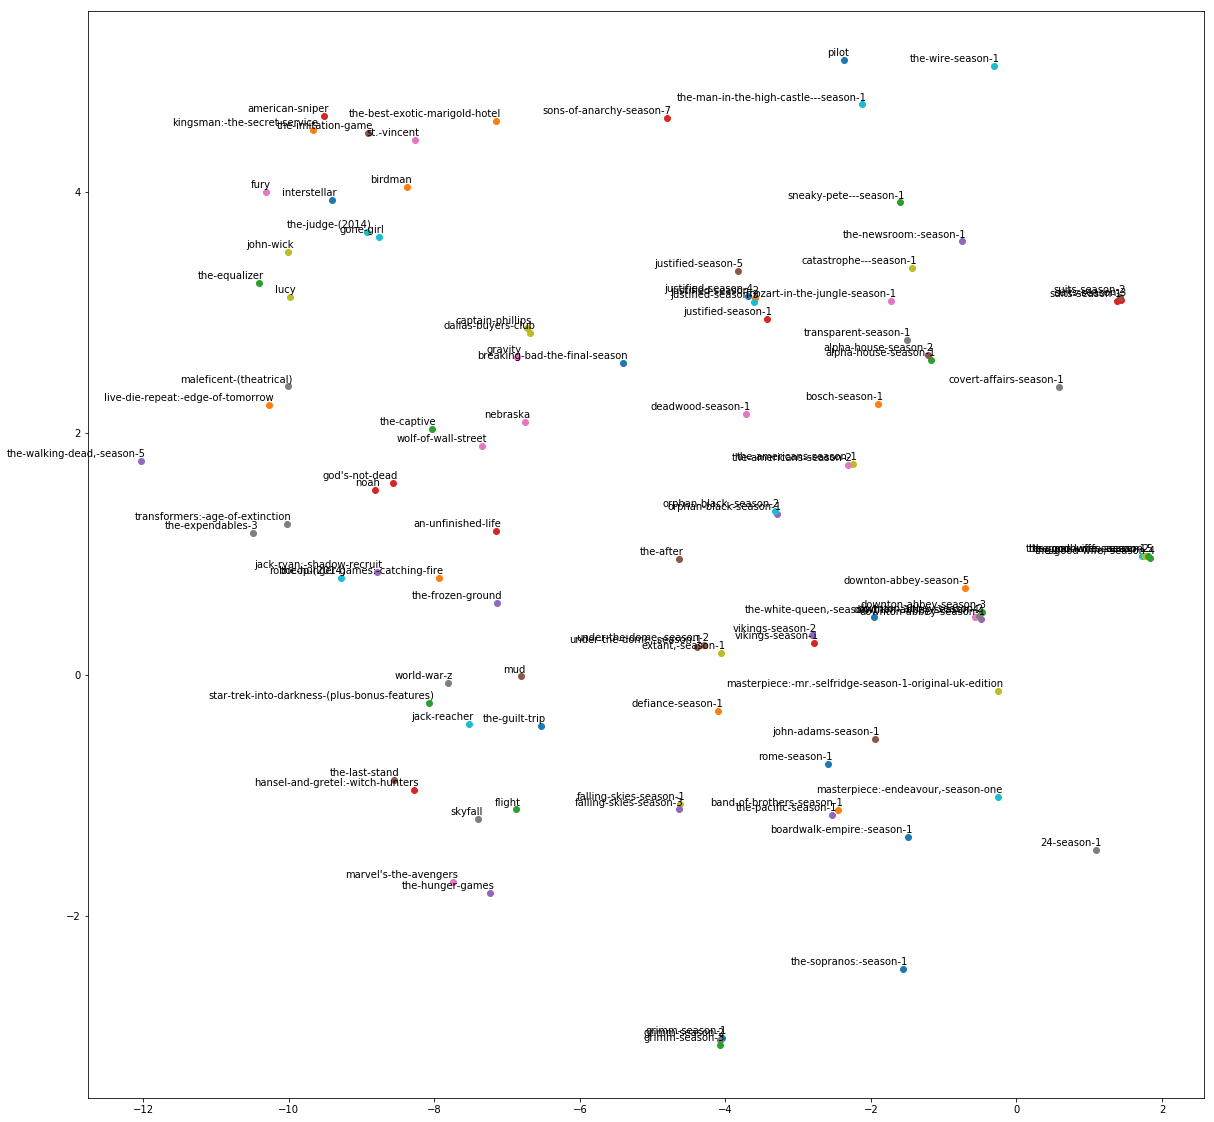

In [55]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(embeddings, product_titles[:100])

---

## Host

Deploy our model to a real-time endpoint.

In [62]:
bt_endpoint = bt.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2018-09-06-05-23-46-507
INFO:sagemaker:Creating endpoint with name blazingtext-2018-09-06-05-01-57-653


--------------------------------------------------------------!

Try generating predictions for a set of titles (some of which are real, some of which are made up).

In [68]:
words = ["sherlock-season-1", 
         "sherlock-season-2",
         "sherlock-season-5",
         'arbitrary-sherlock-holmes-string',
         'the-imitation-game',
         "abcdefghijklmn",
         "keeping-up-with-the-kardashians-season-1"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs_df = pd.DataFrame(json.loads(response))

Calculate correlation and distance.

In [69]:
vecs_df = pd.DataFrame(vecs_df['vector'].values.tolist(), index=vecs_df['word'])

In [70]:
vecs_df = vecs_df.transpose()
vecs_df.corr()

word,sherlock-season-1,sherlock-season-2,sherlock-season-5,arbitrary-sherlock-holmes-string,the-imitation-game,abcdefghijklmn,keeping-up-with-the-kardashians-season-1
word,,,,,,,
sherlock-season-1,1.000000,0.975613,0.937613,0.651827,0.296442,0.186695,0.134656
sherlock-season-2,0.975613,1.000000,0.952221,0.627469,0.274637,0.185511,0.153809
sherlock-season-5,0.937613,0.952221,1.000000,0.649770,0.332390,0.199241,0.180276
arbitrary-sherlock-holmes-string,0.651827,0.627469,0.649770,1.000000,0.397691,0.144972,0.001460
the-imitation-game,0.296442,0.274637,0.332390,0.397691,1.000000,0.342502,0.179073
abcdefghijklmn,0.186695,0.185511,0.199241,0.144972,0.342502,1.000000,0.313100
keeping-up-with-the-kardashians-season-1,0.134656,0.153809,0.180276,0.001460,0.179073,0.313100,1.000000


In [71]:
for column in vecs_df.columns:
    print(column + ':', np.sum((vecs_df[column] - vecs_df['sherlock-season-1']) ** 2))

sherlock-season-1: 0.0
sherlock-season-2: 0.6693818296600973
sherlock-season-5: 1.6195205850083456
arbitrary-sherlock-holmes-string: 7.67011724427113
the-imitation-game: 14.239632481211343
abcdefghijklmn: 12.930583173774579
keeping-up-with-the-kardashians-season-1: 22.867526431909475


Relative to 'sherlock-season-1':
- 'sherlock-season-5' is made up, but relates well with 'sherlock-season-1' and 'sherlock-season-2'
- 'arbitrary-sherlock-holmes-string' is also made up and relates less well but still fairly strong
- 'the-imitation-game' is another popular Prime video title starring Benedict Cumberbatch and has a moderate relationship, but worse than the arbitrary Sherlock title
- 'abcdefghijklmn' is made up and relates even worse
- 'keeping-up-with-the-kardashians-season-1' somehow manages to relate even worse

Clean-up the endpoint

In [61]:
bt_endpoint.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: blazingtext-2018-09-06-05-01-57-653


---

---

# Wrap-up

- Built a recommender system on a large dataset quickly and accurately
- Add more features to extend
- Compare to other methods
- Ensemble two models